# imports

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
os.chdir("/content/drive/MyDrive/into to AI/CS470/")


Mounted at /content/drive/


In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [4]:
import matplotlib.pyplot as plt

# define network


In [5]:
# os.chdir('/content/drive/MyDrive/into to AI/efficient net/')
# !git clone https://github.com/tensorflow/models.git
# git submodule add https://github.com/tensorflow/models.git

In [6]:
os.chdir('/content/drive/MyDrive/into to AI/efficient net/CS470/models/')

import tensorflow as tf

from official.vision.modeling import backbones
from official.vision.modeling import segmentation_model
from official.vision.modeling.decoders import fpn
from official.vision.modeling.heads import segmentation_heads
from official.vision.modeling.decoders import nasfpn

In [7]:
# config used:
# https://github.com/tensorflow/tpu/blob/master/models/official/detection/projects/self_training/configs/pascal_seg_efficientnet-b7-nasfpn.yaml
tf.keras.backend.set_image_data_format('channels_last')

def define_model( pre_trained = False ):
    input_size = 512
    num_classes = 1
    level = 3
    num_convs = 3
    model_id = 'b0'

    backbone = backbones.EfficientNet(model_id=model_id, input_specs = tf.keras.layers.InputSpec(shape=[None, None, None, 4]) )

    decoder = nasfpn.NASFPN(
                      input_specs=backbone.output_specs, 
                      min_level=3, 
                      max_level=7,
                      num_repeats = 7,
                      use_separable_conv = True
                      )

    head = segmentation_heads.SegmentationHead(num_classes = num_classes, 
                                              level=level,
                                              num_convs = num_convs,)

    model = segmentation_model.SegmentationModel(
        backbone=backbone,
        decoder=decoder,
        head=head,
        mask_scoring_head=None,
    )
    return model

In [8]:
model = define_model()

In [9]:
image = tf.ones ([5, 512, 512, 4])

In [10]:
res = model(image)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


# define dataset

In [11]:
# os.chdir("/content/drive/MyDrive/into to AI/")
# !git clone https://github.com/tdiyar/DEXTR-PyTorch.git

# !git clone https://github.com/tdiyar/DEXTR-PyTorch.git
# README.md

# git submodule add https://github.com/scaelles/DEXTR-PyTorch.git
# 

In [12]:
os.chdir("/content/drive/MyDrive/into to AI/CS470/DEXTR-PyTorch/")
import socket
import timeit
from datetime import datetime
import scipy.misc as sm
from collections import OrderedDict
import glob
import numpy as np
import imageio

# PyTorch includes
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.functional import upsample


# Custom includes
from dataloaders.combine_dbs import CombineDBs as combine_dbs
import dataloaders.pascal as pascal
import dataloaders.sbd as sbd
from dataloaders import custom_transforms as tr
import networks.deeplab_resnet as resnet
from layers.loss import class_balanced_cross_entropy_loss
from dataloaders.helpers import *

import torch

In [13]:
use_sbd = False
relax_crop = 50
zero_pad_crop = True
Image_size = 512
testBatch = 5

p = OrderedDict()  # Parameters to include in report

p['trainBatch'] = 5

p['nAveGrad'] = 1  # Average the gradient of several iterations
p['lr'] = 1e-8  # Learning rate
p['wd'] = 0.0005  # Weight decay
p['momentum'] = 0.9  # Momentum


In [14]:
composed_transforms_tr = transforms.Compose([
    tr.RandomHorizontalFlip(),
    tr.ScaleNRotate(rots=(-20, 20), scales=(.75, 1.25)),
    tr.CropFromMask(crop_elems=('image', 'gt'), relax=relax_crop, zero_pad=zero_pad_crop),
    tr.FixedResize(resolutions={'crop_image': (512, 512), 'crop_gt': (512, 512)}),
    tr.ExtremePoints(sigma=10, pert=5, elem='crop_gt'),
    tr.ToImage(norm_elem='extreme_points'),
    tr.ConcatInputs(elems=('crop_image', 'extreme_points')),
    tr.ToTensor()])
composed_transforms_ts = transforms.Compose([
    tr.CropFromMask(crop_elems=('image', 'gt'), relax=relax_crop, zero_pad=zero_pad_crop),
    tr.FixedResize(resolutions={'crop_image': (512, 512), 'crop_gt': (512, 512)}),
    tr.ExtremePoints(sigma=10, pert=0, elem='crop_gt'),
    tr.ToImage(norm_elem='extreme_points'),
    tr.ConcatInputs(elems=('crop_image', 'extreme_points')),
    tr.ToTensor()])

voc_train = pascal.VOCSegmentation(split='train', transform=composed_transforms_tr,)
voc_val = pascal.VOCSegmentation(split='val', transform=composed_transforms_ts, )

if use_sbd:
    sbd = sbd.SBDSegmentation(split=['train', 'val'], transform=composed_transforms_tr, retname=True)
    db_train = combine_dbs([voc_train, sbd], excluded=[voc_val])
else:
    db_train = voc_train

Number of images: 1464
Number of objects: 3507
Number of images: 1449
Number of objects: 3427


In [15]:
p['dataset_train'] = str(db_train)
p['transformations_train'] = [str(tran) for tran in composed_transforms_tr.transforms]
p['dataset_test'] = str(db_train)
p['transformations_test'] = [str(tran) for tran in composed_transforms_ts.transforms]


In [16]:
trainloader = DataLoader(db_train, batch_size=p['trainBatch'], shuffle=True, num_workers=2)
testloader = DataLoader(voc_val, batch_size=testBatch, shuffle=False, num_workers=2)


# train

In [17]:
train_IoU_metric = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=.5)
val_IoU_metric = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=.5)

train_loss_metric = tf.keras.metrics.Mean()
val_loss_metric = tf.keras.metrics.Mean()

In [18]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = tf.math.sigmoid (model(x, training=True)['logits']/255)
        logits = tf.image.resize (logits, (512, 512), method='bilinear',)
        loss_value = loss_fn(y, logits)
    

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    
    train_IoU_metric.update_state(y, logits)

    train_loss_metric.update_state(loss_value)
    return loss_value


In [19]:
@tf.function
def test_step(x, y):
    val_logits = tf.math.sigmoid (model(x, training=False)['logits'])
    val_logits = tf.image.resize (val_logits, (512, 512), method='bilinear',)
    
    val_IoU_metric.update_state(y, val_logits)

    loss_value = loss_fn(y, val_logits)
    val_loss_metric.update_state(loss_value)

In [20]:
model = define_model()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

learning_rate=p['lr']
learning_rate = 1e-4

optimizer = tf.keras.optimizers.SGD ( learning_rate=learning_rate, momentum=p['momentum'], decay=p['wd'])


model.optimizer = optimizer

In [21]:
# checkpoint callback
checkpoint_filepath = '/content/drive/MyDrive/into to AI/CS470/efficient net/checkpointsB0/'
csv_file_name = checkpoint_filepath + 'train_logs.csv'

_callbacks = [tf.keras.callbacks.History(),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath = checkpoint_filepath,
                  monitor='valid_loss',
                  verbose = 1,

                  save_best_only=True,),
              tf.keras.callbacks.ReduceLROnPlateau(monitor="valid_loss", 
                                           factor=0.2, 
                                           patience=10, 
                                           min_lr=1e-8, 
                                          #  min_delta=0.001,
                                           ),
              tf.keras.callbacks.EarlyStopping(monitor="valid_loss", 
                                       patience=10, 
                                       restore_best_weights=True,
                                      #  min_delta=0.05,
                                       ),
              
              tf.keras.callbacks.CSVLogger(csv_file_name, append=True)
              
              ]

callbacks = tf.keras.callbacks.CallbackList(
    _callbacks, add_history=True, model=model)





In [22]:
model.load_weights(checkpoint_filepath)


In [ ]:
resume_epoch = 0
nEpochs = 100
logs = {}
callbacks.on_train_begin(logs=logs)

for epoch in range(resume_epoch, nEpochs):
  logs = {}
  logs['learning_rate'] = float(model.optimizer.learning_rate)

  print(f"====== {epoch}/{nEpochs} epochs : ")

  for ii, sample_batched in enumerate(trainloader):

    inputs, gts = sample_batched['concat'], sample_batched['crop_gt']
    inputs = tf.convert_to_tensor (inputs)
    inputs = tf.transpose(inputs, [0, 2, 3, 1])/255
    gts = tf.convert_to_tensor (gts) # label
    gts = tf.transpose(gts, [0, 2, 3, 1])

    loss_value = train_step(inputs, gts)


  # Display metrics at the end of each epoch.
  train_IoU = train_IoU_metric.result()
  train_loss = train_loss_metric.result()
  logs['loss'] = float(train_loss)
  logs['IoU'] = float(train_IoU)
  # print(f"====== {epoch}/{nEpochs} epochs : ")
  print(f"====== Training IoU over epoch {epoch}: {float(train_IoU)}, loss: {float(train_loss)}")
  train_IoU_metric.reset_states()
  train_loss_metric.reset_states()

  for ii, sample_batched in enumerate(testloader):
    inputs, gts = sample_batched['concat'], sample_batched['crop_gt']
    
    inputs = tf.convert_to_tensor (inputs)
    inputs = tf.transpose(inputs, [0, 2, 3, 1])/255
    gts = tf.convert_to_tensor (gts) # label
    gts = tf.transpose(gts, [0, 2, 3, 1])

    test_step(inputs, gts)


  val_IoU = val_IoU_metric.result()
  val_loss = val_loss_metric.result()

  logs['valid_loss'] = float(val_loss)
  logs['valid_IoU'] = float(val_IoU)
  print(f"====== Validation IoU over epoch {epoch}: {float(val_IoU)}, loss: {float(val_loss)}")
  val_IoU_metric.reset_states()
  val_loss_metric.reset_states()
  print (f'====== logs : {logs}')
  callbacks.on_epoch_end(epoch, logs=logs)
  if model.stop_training:
    break



In [ ]:
# 0.6 train IoU and 0.5 valid IoU was max on the last attempt

In [ ]:
model.load_weights(checkpoint_filepath)

In [23]:

# test dataset
composed_transforms_ts = transforms.Compose([
    tr.CropFromMask(crop_elems=('image', 'gt'), relax=relax_crop, zero_pad=zero_pad_crop),
    tr.FixedResize(resolutions={'gt': None, 'crop_image': (512, 512), 'crop_gt': (512, 512)}),
    tr.ExtremePoints(sigma=10, pert=0, elem='crop_gt'),
    tr.ToImage(norm_elem='extreme_points'),
    tr.ConcatInputs(elems=('crop_image', 'extreme_points')),
    tr.ToTensor()])

db_test = pascal.VOCSegmentation(split='val', transform=composed_transforms_ts, retname=True, download=True)
testloader_test = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)



Files already downloaded and verified
Number of images: 1449
Number of objects: 3427


# model evaluation

In [25]:
def eval_IOU (threshold=.5):
    test_IoU_metric = tf.keras.metrics.BinaryIoU(target_class_ids=[ 1], threshold=threshold)
    test_loss_metric = tf.keras.metrics.Mean()

    @tf.function
    def test_step_test(x, y):
        val_logits = model(x, training=False)['logits']
        val_logits = tf.image.resize (val_logits, (512, 512), method='bilinear',)

        logits_sigmoind = tf.math.sigmoid (val_logits)
        test_IoU_metric.update_state(y, logits_sigmoind)

        loss_value = loss_fn(y, val_logits)
        test_loss_metric.update_state(loss_value)


    for ii, sample_batched in enumerate(testloader_test):
        inputs, gts = sample_batched['concat'], sample_batched['crop_gt']
        
        inputs = tf.convert_to_tensor (inputs)
        inputs = tf.transpose(inputs, [0, 2, 3, 1])/255
        gts = tf.convert_to_tensor (gts) # label
        gts = tf.transpose(gts, [0, 2, 3, 1])

        break
        test_step_test(inputs, gts)

    
    test_IoU = test_IoU_metric.result()
    test_loss = test_loss_metric.result()
    print(f"Test dataset results: IoU - {float(test_IoU)}, loss - {test_loss}")
    test_IoU_metric.reset_states()
    test_loss_metric.reset_states()
    return test_IoU


In [24]:
model

In [26]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
anss = []
for thres in thresholds:
  anss.append(eval_IOU (threshold=thres) )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Test dataset results: IoU - 0.6287949085235596, loss - 0.7728122472763062
Test dataset results: IoU - 0.6626113653182983, loss - 0.7731491327285767
Test dataset results: IoU - 0.6770493388175964, loss - 0.7717097997665405
Test dataset results: IoU - 0.6763550043106079, loss - 0.7708390355110168
Test dataset results: IoU - 0.6563729643821716, loss - 0.7744114995002747
Test dataset results: IoU - 0.6136735081672668, loss - 0.7704431414604187
Test dataset results: IoU - 0.5315883159637451, loss - 0.7756937742233276
Test dataset results: IoU - 0.4021005928516388, loss - 0.7702778577804565
Test dataset results: IoU - 0.21714867651462555, loss - 0.7742606997489929


In [27]:
anss

[<tf.Tensor: shape=(), dtype=float32, numpy=0.6287949>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.66261137>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.67704934>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.676355>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65637296>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6136735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5315883>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4021006>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.21714868>]

In [29]:
sum(anss)/len(anss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.562855>

# results illustrations:

In [115]:
ds_iter = iter (testloader_test)

In [153]:
for i in range(20):
  sample_batched = next(ds_iter)

In [178]:
sample_batched = next(ds_iter)
inputs, gts = sample_batched['concat'], sample_batched['crop_gt']

inputs = tf.convert_to_tensor (inputs)
inputs = tf.transpose(inputs, [0, 2, 3, 1])/255
gts = tf.convert_to_tensor (gts) # label
gts = tf.transpose(gts, [0, 2, 3, 1])



In [179]:
inputs.shape

TensorShape([1, 512, 512, 4])

In [180]:
sample_batched['crop_image'].shape

torch.Size([1, 3, 512, 512])

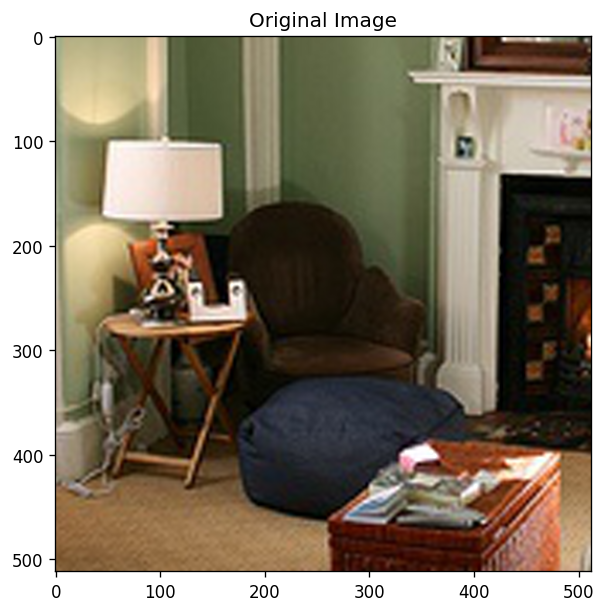

In [181]:

fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True, dpi = 120)
ax.imshow ( inputs[0, :, :, :3] )
ax.set_title('Original Image')
fig.set_facecolor('white')

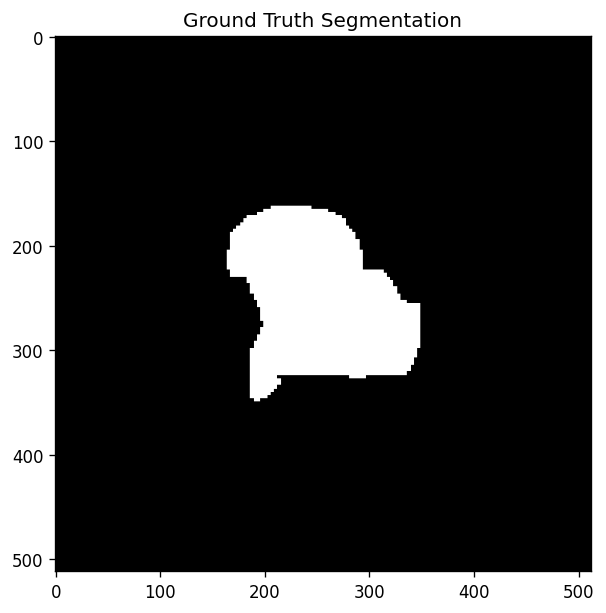

In [182]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True, dpi = 120)
ax.imshow ( gts[0, :, :, 0], cmap='gray', )
ax.set_title('Ground Truth Segmentation')
fig.set_facecolor('white')


In [183]:
val_logits = model(inputs, training=False)['logits']
val_logits = tf.image.resize (val_logits, (512, 512), method='bilinear',)
logits_sigmoind = tf.math.sigmoid (val_logits)


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [176]:
threshold = 0.3
test_IoU_metric = tf.keras.metrics.BinaryIoU(target_class_ids=[ 1], threshold=threshold)

In [177]:
test_IoU_metric(gts, logits_sigmoind)

<tf.Tensor: shape=(), dtype=float32, numpy=0.55772316>

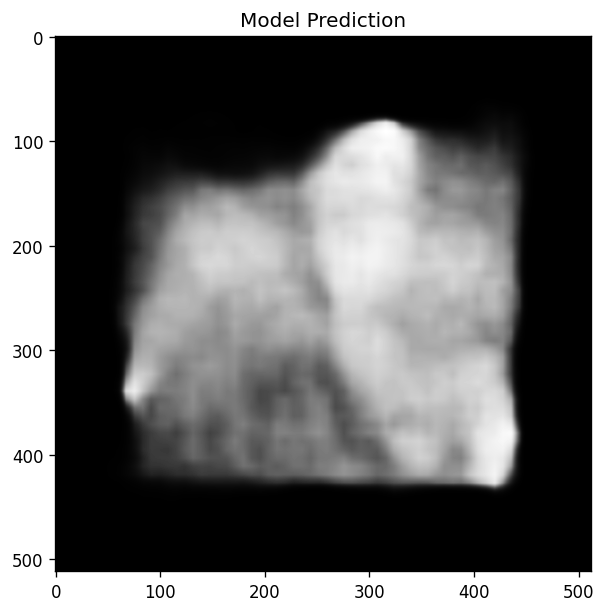

In [162]:
# plt

fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True, dpi = 120)
ax.imshow ( logits_sigmoind[0, :, :, 0], cmap='gray'  )
ax.set_title('Model Prediction')
fig.set_facecolor('white')



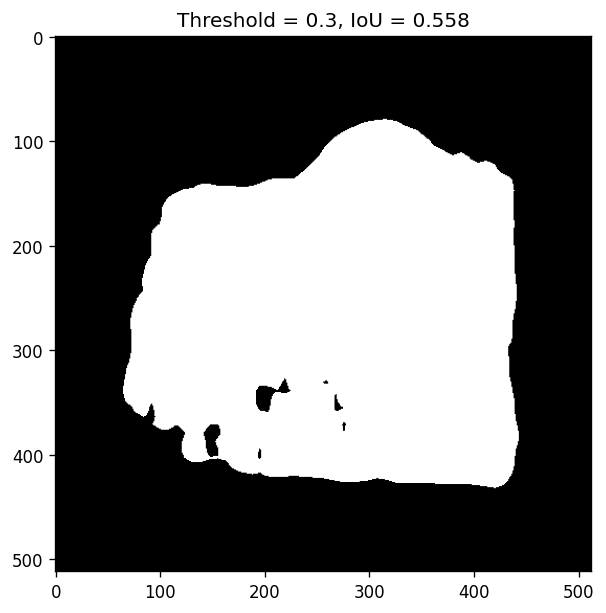

In [163]:
# plt
IoU = float(test_IoU_metric(gts, logits_sigmoind))
IoU = round(IoU, 3)

fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True, dpi = 120)
ax.imshow ( logits_sigmoind[0, :, :, 0] >threshold, cmap='gray'  )
ax.set_title( f'Threshold = {threshold}, IoU = {IoU}')
fig.set_facecolor('white')



# checking input outputs

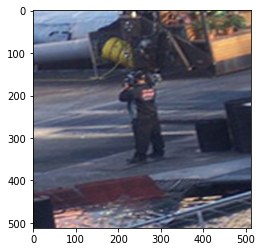

In [ ]:
plt.imshow ( inputs[2, :, :, :3]/256 )

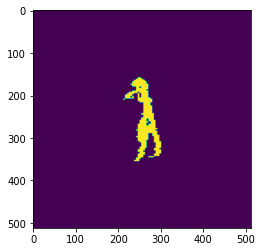

In [ ]:
plt.imshow ( gts[2, :, :, 0] )

In [ ]:
inputs.shape

TensorShape([5, 512, 512, 4])

In [ ]:
outputs = model(inputs/256)['logits']
outputs = tf.image.resize (outputs, (512, 512), method='bilinear',)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


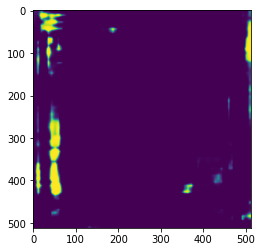

In [ ]:
output_sigmoind = tf.math.sigmoid (outputs)
plt.imshow ( output_sigmoind[0, :, :, 0] ) 

In [ ]:
p['nAveGrad']

1

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
loss(gts, outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=5.929792>

In [ ]:
outputs.shape

TensorShape([5, 512, 512, 1])

In [ ]:
loss (gts, outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
m = tf.keras.metrics.BinaryIoU(target_class_ids=[ 1], threshold=.5)

In [ ]:
output_sigmoind = tf.math.sigmoid (outputs)
m (gts, output_sigmoind)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0022084725>

# old model experiment

In [ ]:
gpu_id = 0
device = torch.device("cuda:"+str(gpu_id) if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Network definition
modelName = 'dextr_pascal'
nInputChannels = 4
classifier = 'psp'
net = resnet.resnet101(1, pretrained=False, nInputChannels=nInputChannels, classifier=classifier)
net.to (device)

In [ ]:
for ii, sample_batched in enumerate(trainloader):

      inputs_torch, gts_torch = sample_batched['concat'], sample_batched['crop_gt']
      inputs_torch = inputs_torch.to (device)
      # inputs = tf.convert_to_tensor (inputs)
      # inputs = tf.transpose(inputs, [0, 2, 3, 1])
      # gts = tf.convert_to_tensor (gts)
      # gts = tf.transpose(gts, [0, 2, 3, 1])

      break

In [ ]:
output_torch = net(inputs_torch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
torch.min(output_torch)

tensor(-0.8625, device='cuda:0', grad_fn=<MinBackward1>)